<a href="https://colab.research.google.com/github/LuccasBracci/Winery-Price-Modeling/blob/main/WineModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
try:
    import vonage
except ImportError:
    !pip install vonage
    import vonage

import sys
import asyncio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import joblib
import os

from google.colab import drive

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, LogisticRegression

# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers, regularizers
# from tensorflow.keras.layers import Dense, Dropout, Conv2D
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.230
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4400.46
clflush size	: 64
cache_alignment	: 64
addres

In [61]:
plt.style.use('dark_background')

In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
file = '/content/drive/MyDrive/Coding Dojo | Data Science/Stack 2: Machine Learning/Week 3: Classification Models/Data/wines_SPA.csv'

###### Custom Functions

In [64]:
'''
Running this function will loop through all rows in the specified column
and remove ascii characters (excluding decimal points) from values.

The key arguments are:
df: dataframe
col: dataframe column
rep: character that replaces ascii (usually a decimal point)

'''

def clean_cols(df, col, rep):
    
    # Loop through columns within the dataframe for the length of rows in the specified column
    for i in range(len(df[col])):

        # Search for and resub values within the cell respective to the index
        num = re.sub(r'[^0-9\.]+',rep, df[col][i])  
        
        # Assigns new value to the cell of the respective index 
        df[col][i] = float(num)
        
    return df

In [65]:
'''
Running this function will loop through all rows in the specified column and returns
the values that contains an ascii character (excluding decimal points)

'''

def search_cols(df, col):
    
    # Loop through columns within the dataframe for the length of rows in the specified column
    for i in range(len(df[col])):

        # Search for values within the cell respective to the index
        num = re.search(r'[^0-9\.]+', df[col][i])  
        
    return df

In [66]:
'''
This function loops through the dataframe columns and prints the 
data type, column name, and unique elements within the column.

There are three kwargs; 

col allows the user to specify the column of interest,

show_count will toggle the value_counts function, 

sort_values sorts the data in ascending order.

'''

def LU(df, col=None, show_count=False, sort_values=False):

    if col is not None:
        unique_vals = df[col].unique()
        if sort_values:
            unique_vals = sorted(unique_vals) 

        print(col,
              '\n',
              df[col].dtype,
              '\n\n',
              unique_vals,
              '\n',
              df[col].value_counts() if show_count else "",
              '\n'
              )
    else:
        for i in df.columns:
            unique_vals = df[i].unique()
            if sort_values:
                unique_vals = sorted(unique_vals)

            print(i,
                  '\n',
                  df[i].dtype,
                  '\n\n',
                  unique_vals,
                  '\n',
                  df[i].value_counts() if show_count else "",
                  '\n'
                  )

In [67]:
'''
L(ist)M(issing) function loops through columns and calculates the degree
of missing data and prints value as a percentage

'''

def LM(df, sort_by_missing=True, perc_min=0):
    missing_perc = df.isna().mean() * 100
    missing_perc = missing_perc[missing_perc > perc_min]
    missing_perc = missing_perc.sort_values(ascending=False) if sort_by_missing else missing_perc.index
    
    missing_cols = []
    for col in missing_perc.index:
        unique_vals = df[col].unique()
        print(f"{col} ({df[col].dtype}): {missing_perc[col]:.2f}% missing values")
        print(f"Unique values: {unique_vals}\n")
        missing_cols.append(col)
        
    return missing_cols

# Explore Dataset

In [68]:
df = pd.read_csv(file)

In [69]:
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


In [71]:
row_df, col_df = df.shape

print(f'There are {row_df} rows and {col_df} columns')

There are 7500 rows and 11 columns


# Cleaning Wine Sales

In [72]:
LM(df)

body (float64): 15.59% missing values
Unique values: [ 5.  4.  3. nan  2.]

acidity (float64): 15.59% missing values
Unique values: [ 3.  2.  1. nan]

type (object): 7.27% missing values
Unique values: ['Toro Red' 'Tempranillo' 'Ribera Del Duero Red' 'Pedro Ximenez' 'Red'
 'Sherry' 'Priorat Red' 'Rioja Red' 'Rioja White' 'Grenache' nan 'Cava'
 'Verdejo' 'Syrah' 'Monastrell' 'Mencia' 'Sparkling' 'Montsant Red'
 'Albarino' 'Chardonnay' 'Cabernet Sauvignon' 'Sauvignon Blanc']

year (object): 0.03% missing values
Unique values: ['2013' '2018' '2009' '1999' '1996' '1998' '2010' '1995' '2015' '2011'
 '2016' '1970' '1946' '1962' '2019' '2004' 'N.V.' '1931' '1979' '2005'
 '2020' '2014' '1985' '1929' '2007' '2012' '2017' '2008' nan '2006' '2000'
 '2003' '2002' '1991' '1994' '1990' '1989' '1987' '1986' '1981' '2001'
 '1968' '1964' '1982' '1974' '1983' '1955' '1980' '1972' '1953' '1958'
 '1942' '1965' '1992' '1973' '1997' '1967' '1975' '1910' '1961' '1954'
 '1988' '1969' '1951' '1928' '1976' '194

['body', 'acidity', 'type', 'year']

In [73]:
df.head(20)

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00000,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50000,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95000,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96000,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06000,Ribera Del Duero Red,5.0,3.0
5,Vega Sicilia,Unico,1998,4.8,1209,Espana,Ribera del Duero,490.00000,Ribera Del Duero Red,5.0,3.0
6,Vega Sicilia,Unico,2010,4.8,1201,Espana,Ribera del Duero,349.00000,Ribera Del Duero Red,5.0,3.0
7,Vega Sicilia,Unico,1995,4.8,926,Espana,Ribera del Duero,810.89000,Ribera Del Duero Red,5.0,3.0
8,Vega Sicilia,Unico Reserva Especial Edicion,2015,4.8,643,Espana,Ribera del Duero,345.00000,Ribera Del Duero Red,5.0,3.0
9,Vega Sicilia,Unico,2011,4.8,630,Espana,Ribera del Duero,315.00000,Ribera Del Duero Red,5.0,3.0


In [74]:
df['year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7500 entries, 0 to 7499
Series name: year
Non-Null Count  Dtype 
--------------  ----- 
7498 non-null   object
dtypes: object(1)
memory usage: 58.7+ KB


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


## The column country only consists of one item. This column can be dropped.

In [76]:
df.drop('country', axis=1, inplace= True)

# Address inconsitencies per column

In [77]:
# Looping through columns so I can identify missing data, which column they belong to, and data type of the column.

for col in df:
  print(col, df[col].isna().sum(), df[col].dtypes)

winery 0 object
wine 0 object
year 2 object
rating 0 float64
num_reviews 0 int64
region 0 object
price 0 float64
type 545 object
body 1169 float64
acidity 1169 float64


The missing values in the object type columns can be imputed after splitting using one hot encoder or ordinal encoding. Missing values in float64 type columns can be imputed now. These types of columns describe teirs/ordinal values and can be reasonably assumed.

In [78]:
asdf, wert = df.shape

1169/asdf

0.15586666666666665

### Body

In [79]:
# Lets start with body

LU(df, 'body')

body 
 float64 

 [ 5.  4.  3. nan  2.] 
  



In [80]:
# It can be assumed that the missing value is '1'

df['body'].fillna(1, inplace= True)

LU(df, 'body')

body 
 float64 

 [5. 4. 3. 1. 2.] 
  



In [81]:
# Then we can convert it to an int64

df['body'] = df['body'].astype('int64')

LU(df, 'body')

body 
 int64 

 [5 4 3 1 2] 
  



### Acidity

In [82]:
# Next is 'acidity'
# I can be assumed that acidity is refering to the pH value of wine. This rating goes from 2.5 to 4.5

LU(df, 'acidity')

acidity 
 float64 

 [ 3.  2.  1. nan] 
  



In [83]:
# However, these values are clearly ordinal numbers. So we can assume that the missing value would be 4.

df['acidity'].fillna(4, inplace= True)

In [84]:
# Then we can convert it to an int64

df['acidity'] = df['acidity'].astype('int64')

In [85]:
LU(df, 'acidity')

acidity 
 int64 

 [3 2 1 4] 
  



[wine acidity reference](https://winefolly.com/deep-dive/understanding-acidity-in-wine/)

### Year

In [86]:
# Lets explore the 'year' column. There is incongruent data that can probably be reasonbly be imputed.

LU(df, 'year')

year 
 object 

 ['2013' '2018' '2009' '1999' '1996' '1998' '2010' '1995' '2015' '2011'
 '2016' '1970' '1946' '1962' '2019' '2004' 'N.V.' '1931' '1979' '2005'
 '2020' '2014' '1985' '1929' '2007' '2012' '2017' '2008' nan '2006' '2000'
 '2003' '2002' '1991' '1994' '1990' '1989' '1987' '1986' '1981' '2001'
 '1968' '1964' '1982' '1974' '1983' '1955' '1980' '1972' '1953' '1958'
 '1942' '1965' '1992' '1973' '1997' '1967' '1975' '1910' '1961' '1954'
 '1988' '1969' '1951' '1928' '1976' '1949' '2021' '1959' '1922' '1978'
 '1925'] 
  



In [87]:
df

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Toro,995.00,Toro Red,5,3
1,Artadi,Vina El Pison,2018,4.9,31,Vino de Espana,313.50,Tempranillo,4,2
2,Vega Sicilia,Unico,2009,4.8,1793,Ribera del Duero,324.95,Ribera Del Duero Red,5,3
3,Vega Sicilia,Unico,1999,4.8,1705,Ribera del Duero,692.96,Ribera Del Duero Red,5,3
4,Vega Sicilia,Unico,1996,4.8,1309,Ribera del Duero,778.06,Ribera Del Duero Red,5,3
...,...,...,...,...,...,...,...,...,...,...
7495,Contino,Reserva,2016,4.2,392,Rioja,19.98,Rioja Red,4,3
7496,Conreria d'Scala Dei,Les Brugueres,2018,4.2,390,Priorato,16.76,Priorat Red,4,3
7497,Mustiguillo,Finca Terrerazo,2017,4.2,390,El Terrerazo,24.45,Red,4,3
7498,Matarromera,Gran Reserva,2011,4.2,389,Ribera del Duero,64.50,Ribera Del Duero Red,5,3


### Drop NaNs

In [88]:
# df.dropna(inplace=True)

### Ratings

In [89]:
LU(df, 'rating')

rating 
 float64 

 [4.9 4.8 4.7 4.6 4.5 4.4 4.3 4.2] 
  



In [90]:
df['rating'].isna().sum()

0

In [91]:
# This cell converts the ratings values into ordinal catagories in ranges (M)edium, (G)ood, and (O)utstanding. These labels can be used later but now they are encoded.

ratings  = [4.9, 4.8, 4.7, 4.6, 4.5, 4.4, 4.3, 4.2]

bins = [4.2, 4.4, 4.6, 5]

labels = ['M', 'G', 'O']

df['ratings'] = pd.cut(df['rating'], bins=bins, labels=labels)

print(df['ratings'].isna().sum())

df['ratings'].replace({'M': 1, 'G': 2, 'O': 3}, inplace=True)

df['ratings'] = df['ratings'].cat.codes.astype('int64')

5679


In [92]:


df['ratings'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7500 entries, 0 to 7499
Series name: ratings
Non-Null Count  Dtype
--------------  -----
7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


### Drop Duplicates

In [93]:
df.shape

(7500, 11)

In [94]:
# Count amount of duplicated rows

df.duplicated().sum()

5452

In [95]:
# Drop duplicates 

df.drop_duplicates(inplace=True)

In [96]:
# Ensure duplicates were dropped

df.duplicated().sum()

0

In [97]:
# Check shape of dataframe to ensure it will still be valid

df.shape

(2048, 11)

In [98]:
LU(df,'price',1);

price 
 float64 

 [995.   313.5  324.95 ...  16.76  24.45  31.63] 
 75.00     16
95.00     12
34.90     12
59.90     12
26.90     11
          ..
75.92      1
47.52      1
94.20      1
185.15     1
995.00     1
Name: price, Length: 1292, dtype: int64 



## Drop Missing Values

In [99]:
df.dropna(inplace = True)
df.shape

(1940, 11)

# Visualizations

<Axes: >

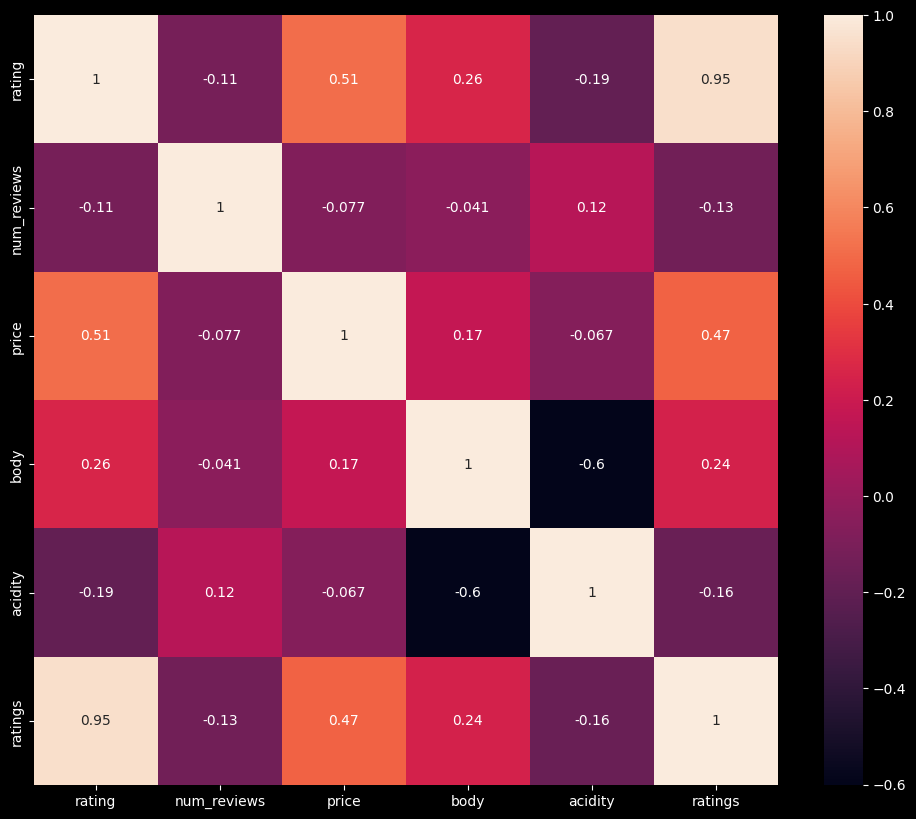

In [100]:
dfcorr = df.corr()
plt.subplots(figsize=(12,10))
sns.heatmap(dfcorr, annot=True)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1940 entries, 0 to 6100
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       1940 non-null   object 
 1   wine         1940 non-null   object 
 2   year         1940 non-null   object 
 3   rating       1940 non-null   float64
 4   num_reviews  1940 non-null   int64  
 5   region       1940 non-null   object 
 6   price        1940 non-null   float64
 7   type         1940 non-null   object 
 8   body         1940 non-null   int64  
 9   acidity      1940 non-null   int64  
 10  ratings      1940 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 181.9+ KB


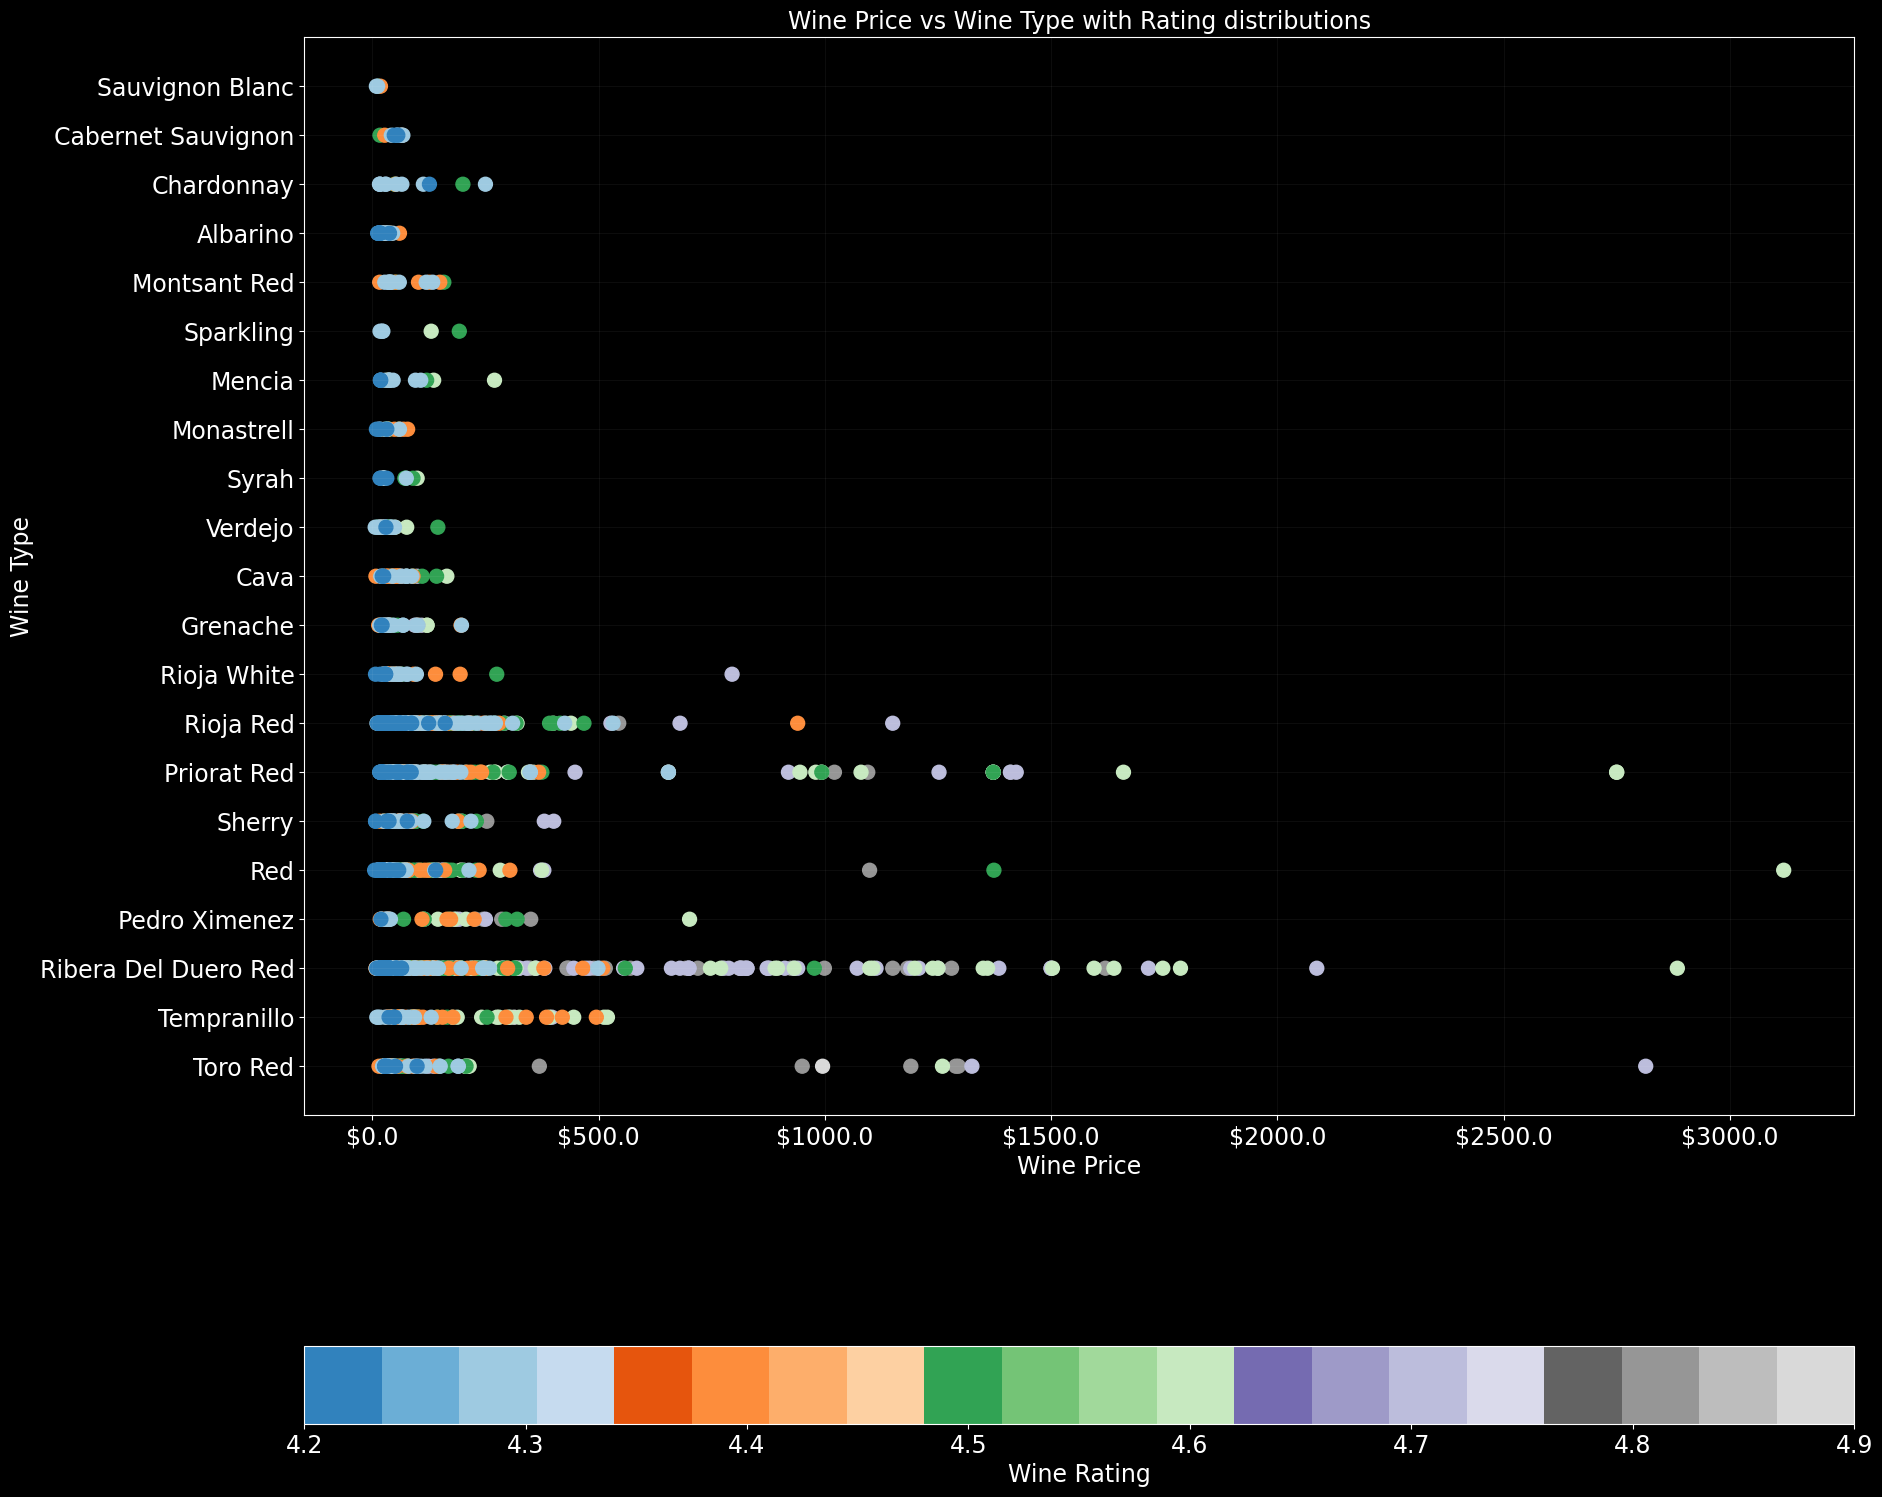

In [102]:
font = 17
def mon_fmt(a,g):
  return f'${a*1e0}'
f,ax = plt.subplots(figsize=(20,20))

c= df['rating']
cmeans = df['price'].mean()
plt.scatter(df['price'], df['type'],c=c, cmap ='tab20c', s=100)

cb = plt.colorbar(orientation='horizontal')
cb.set_label(label = 'Wine Rating',fontsize=font)
cb.ax.tick_params(labelsize=font)

xt, yt = plt.xticks, plt.yticks
xt(fontsize=font)
yt(fontsize=font)

plt.xlabel('Wine Price', fontsize=font)
plt.ylabel('Wine Type', fontsize=font)

ax.xaxis.set_major_formatter(mon_fmt)
ax.set_title('Wine Price vs Wine Type with Rating distributions', fontsize=font)

plt.grid(True, alpha=.05)
plt.show()

## There are noticeable differences in pricing in wines and level of rating as the price increases. Higher rated wines have a notably higher mark up price.

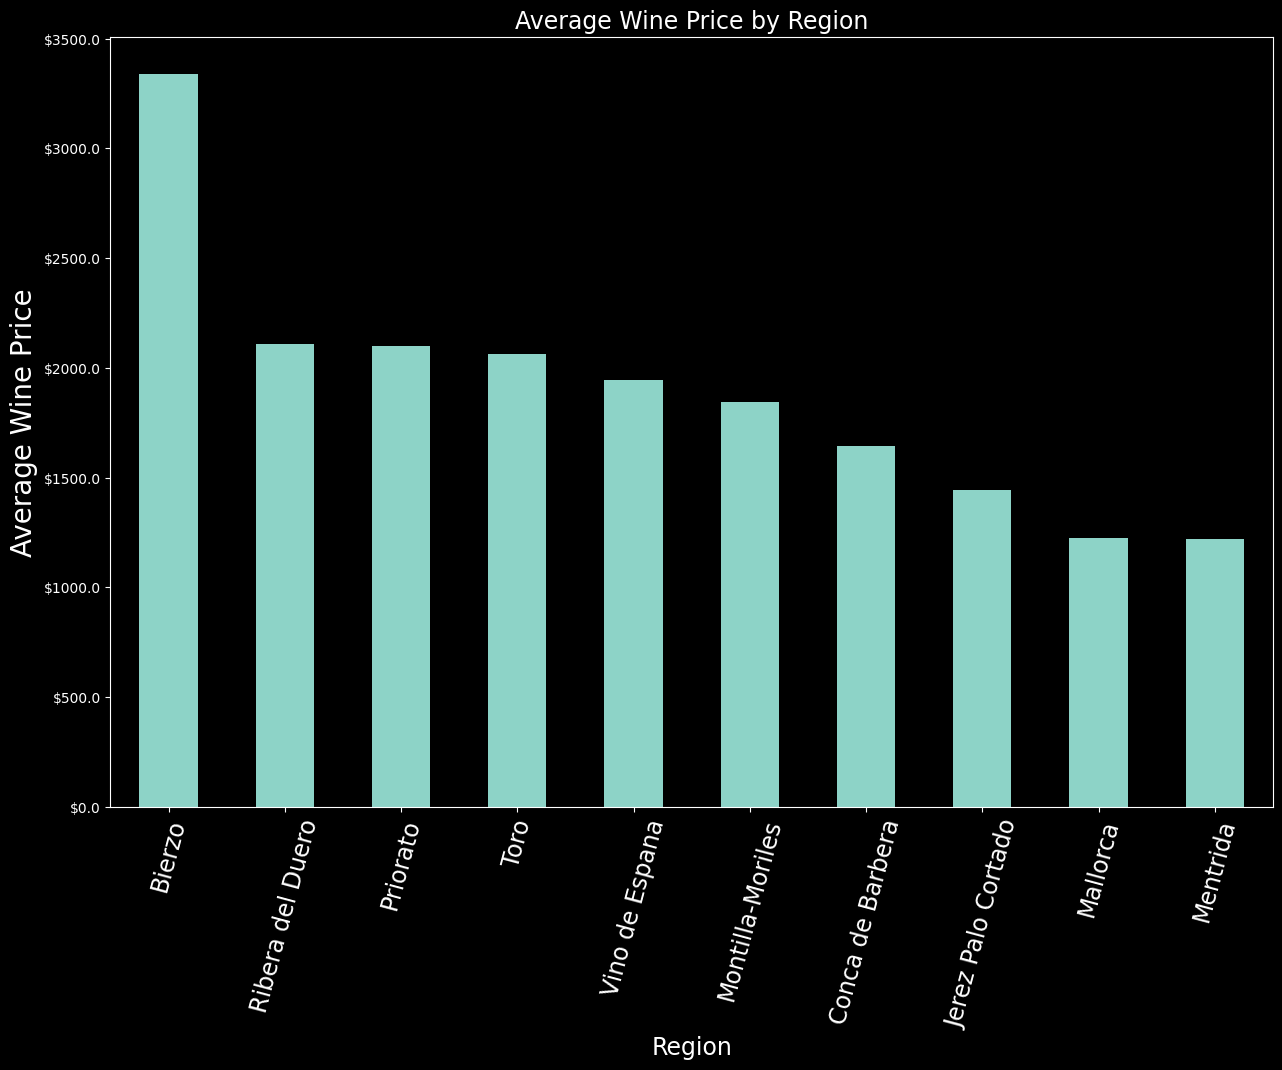

In [103]:
avg_price_by_region = df.groupby('region')['price'].mean().sort_values(ascending=0)

def mon_fmt(a,g):
  return f'${a*1e1}'



# Create a bar plot of the average wine price by region
fig, ax = plt.subplots(figsize=(15, 10))
avg_price_by_region.head(10).plot(kind='bar', y='rating', ax=ax)
# Set the labels and title
ax.set_xlabel('Region', fontsize=font)
ax.set_ylabel('Average Wine Price', fontsize=20)
ax.set_title('Average Wine Price by Region',fontsize=font)
ax.yaxis.set_major_formatter(mon_fmt)

plt.xticks(rotation=75,fontsize=font)
# Show the plot
plt.show()

## Displayed is is the top 10 ordered mean price of wine by region. The left most regions have higher wine prices which offer better investment opportunity.


# T_T_S

In [104]:
# Train test split
y = df['price']

X = df.drop(columns=['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Feature Engineering

In [105]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('ordinal', OrdinalEncoder(categories='auto'))
])

In [106]:
num_cols = make_column_selector(dtype_include=['int', 'float'])

cat_cols = make_column_selector(dtype_include=object)

ord_cols = make_column_selector(pattern='body|acidity|rating')

In [107]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols),
    ('ord', ord_transformer, ord_cols)
])

In [108]:
# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted transformer
X_test_preprocessed = preprocessor.transform(X_test)

# Model Evaluation

## Linear Regression Model

In [109]:
X_sample = X_train.shape[0]

y_sample = y_train.shape[0]

X_sample + y_sample

2910

In [110]:
pca = PCA()

In [111]:
GradBoost = GradientBoostingRegressor()

In [112]:
GradBoostPipe = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('regressor', GradBoost)])

In [113]:
GradBoostPipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fd585de8d30>),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fd585de8370>),
                                   ('ord',
                 

In [114]:
c_val = np.logspace(-3, 2, num=10)
c_val = c_val.tolist()
print(c_val)

[0.001, 0.003593813663804626, 0.01291549665014884, 0.046415888336127795, 0.1668100537200059, 0.5994842503189409, 2.1544346900318843, 7.742636826811277, 27.825594022071257, 100.0]


In [115]:
GradBoostparams = {
  'regressor__n_estimators': [300],
  'pca__n_components': [0.95,1,1.1 ],
  'regressor__alpha': [0.0001]
}

In [116]:
GradBoostGrid = GridSearchCV(GradBoostPipe, GradBoostparams, cv=6)

In [117]:
%%time

GradBoostGrid.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [118]:
%%time

y_pred = GradBoostGrid.predict(X_test)

# Calculate metrics
GradBoostmse = mean_squared_error(y_test, y_pred)
GradBoostr2 = r2_score(y_test, y_pred)
GradBoostevs = explained_variance_score(y_test, y_pred)

print(f"Mean Squared Error: {GradBoostmse:.2f}")
print(f"R^2 Score: {GradBoostr2:.2f}")
print(f"Explained Variance Score: {GradBoostevs:.2f}")

NotFittedError: ignored

In [119]:
GradBoostGrid.best_params_

AttributeError: ignored

In [ ]:
GradBoostBest = GradBoostGrid.best_estimator_

In [ ]:
GradBoostBest.fit(X_train, y_train)

In [ ]:
import os

GradBestFile = '/content/drive/MyDrive/Coding Dojo | Data Science/SavedModels/GradBestFile.joblib'

if not os.path.exists(os.path.dirname(GradBestFile)):
    os.makedirs(os.path.dirname(GradBestFile))

joblib.dump(GradBoostBest, GradBestFile)

In [ ]:
%%time

GradBoostBest_pred = GradBoostBest.predict(X_test)

# Calculate metrics
GradBestmse = mean_squared_error(y_test, GradBoostBest_pred)
GradBestr2 = r2_score(y_test, GradBoostBest_pred)
GradBestevs = explained_variance_score(y_test, GradBoostBest_pred)

print(f"Mean Squared Error: {GradBestmse:.2f}")
print(f"R^2 Score: {GradBestr2:.2f}")
print(f"Explained Variance Score: {GradBestevs:.2f}")

## Random Forest Regression

In [ ]:
pca = PCA()

In [ ]:
Ranforreg = RandomForestRegressor()
Ranforreg .get_params()

In [ ]:
RanforregPipe = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('regressor', Ranforreg)])
RanforregPipe.get_params()

In [ ]:
Ranforregparams = {
     'pca__n_components': [0.95, 0.955, 0.96],

     'regressor__ccp_alpha': [0.0002, 0.0003]
}

In [ ]:
# Perform grid search with cross-validation
%%time

RanforregGrid = GridSearchCV(RanforregPipe, Ranforregparams, cv=10)
 
RanforregGrid.fit(X_train, y_train)

In [ ]:
RanforregGrid.best_params_

In [ ]:
# Predict on test set
RanforregGrid_pred = RanforregGrid.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, RanforregGrid_pred)
r2 = r2_score(y_test, RanforregGrid_pred)
evs = explained_variance_score(y_test, RanforregGrid_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Explained Variance Score: {evs:.2f}")

In [ ]:
RanforregGrid.best_params_

In [ ]:
RanforregGridbest = RanforregGrid.best_estimator_

In [ ]:
RanforregGridbest.fit(X_train, y_train)

In [ ]:
# Predict on test set
RanforregGridBestpred = RanforregGridbest.predict(X_test)

# RanforregCalculate metrics

RanforregGridBestmse = mean_squared_error(y_test, RanforregGridBestpred)
RanforregGridBestr2 = r2_score(y_test, RanforregGridBestpred)
RanforregGridBestevs = explained_variance_score(y_test, RanforregGridBestpred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Explained Variance Score: {evs:.2f}")

## Bagging Regressor

In [120]:
BagReg = BaggingRegressor()
BagReg.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [121]:
BagRegPipe = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('regressor', BagReg)])
BagRegPipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fd585de8d30>),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fd585de8370>),
                                   ('ord',
                 

In [122]:
BagRegParams = {
  'regressor__n_estimators': [275,300,325],
  'pca__n_components': [0.85,0.87, .9,0.91, 0.92, 0.95 ],
  'regressor__alpha': [0.00009,0.0001,0.0002]
}

In [123]:
BagRegGrid = GridSearchCV(GradBoostPipe,BagRegParams,cv=5)

In [ ]:
%%time

BagRegGrid.fit(X_train, y_train)

In [ ]:
BagRegGrid_pred = BagRegGrid.predict(X_test)

# Calculate metrics
BagRegmse = mean_squared_error(y_test, BagRegGrid_pred)
BagRegr2 = r2_score(y_test, BagRegGrid_pred)
BagRegevs = explained_variance_score(y_test, BagRegGrid_pred)

print(f"Mean Squared Error: {BagRegmse = mean_squared_error(y_test, BagRegGrid_pred):.2f}")
print(f"R^2 Score: {BagRegr2:.2f}")
print(f"Explained Variance Score: {BagRegevs:.2f}")